In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Adapted from: 
# lqr_neural_error_dynamics.ipynb

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [3]:
%matplotlib notebook

### Load Experimental Data

In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

True
('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


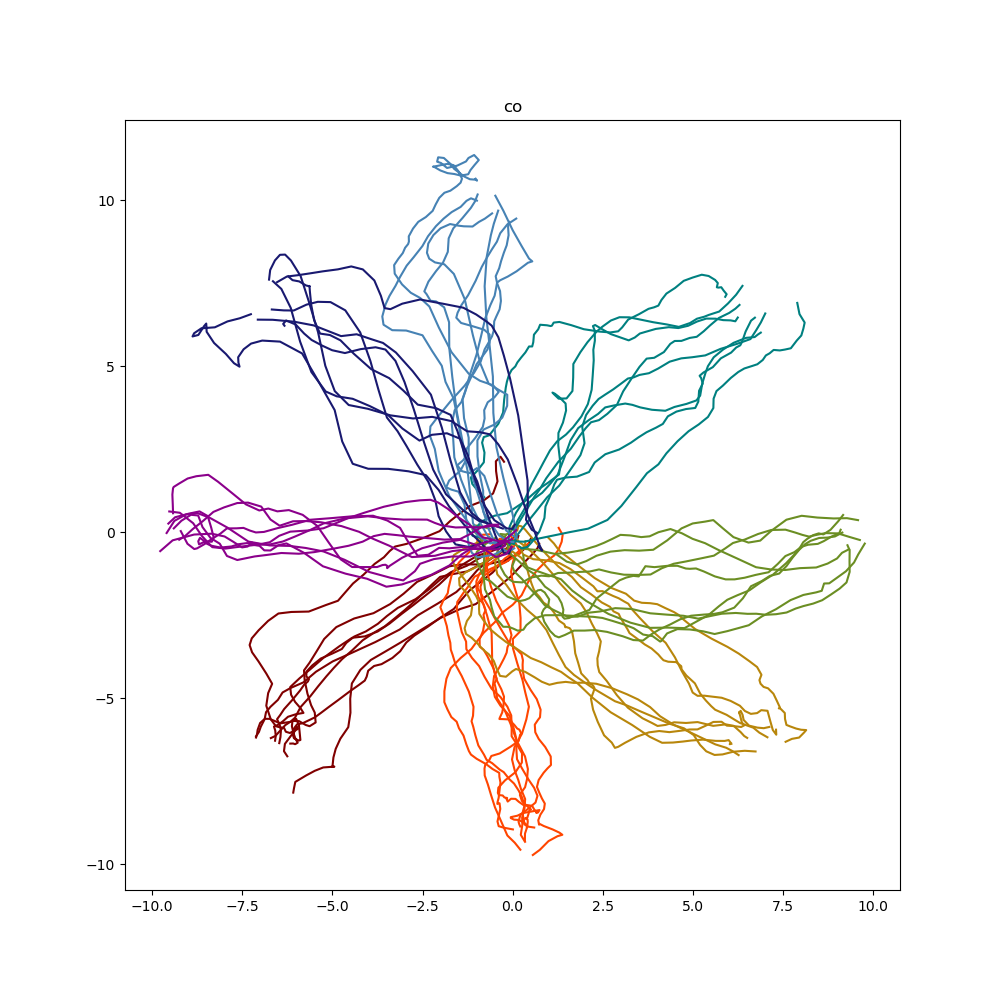

<IPython.core.display.Javascript object>


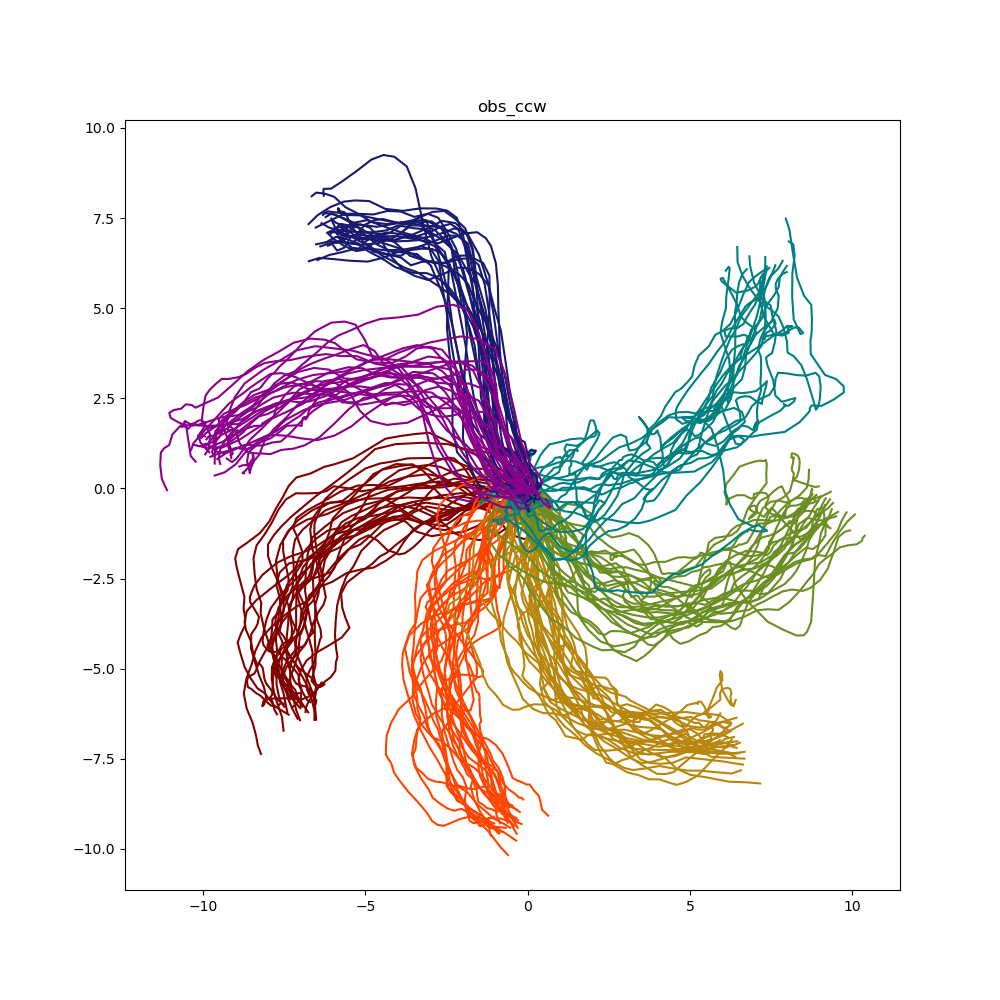

<IPython.core.display.Javascript object>


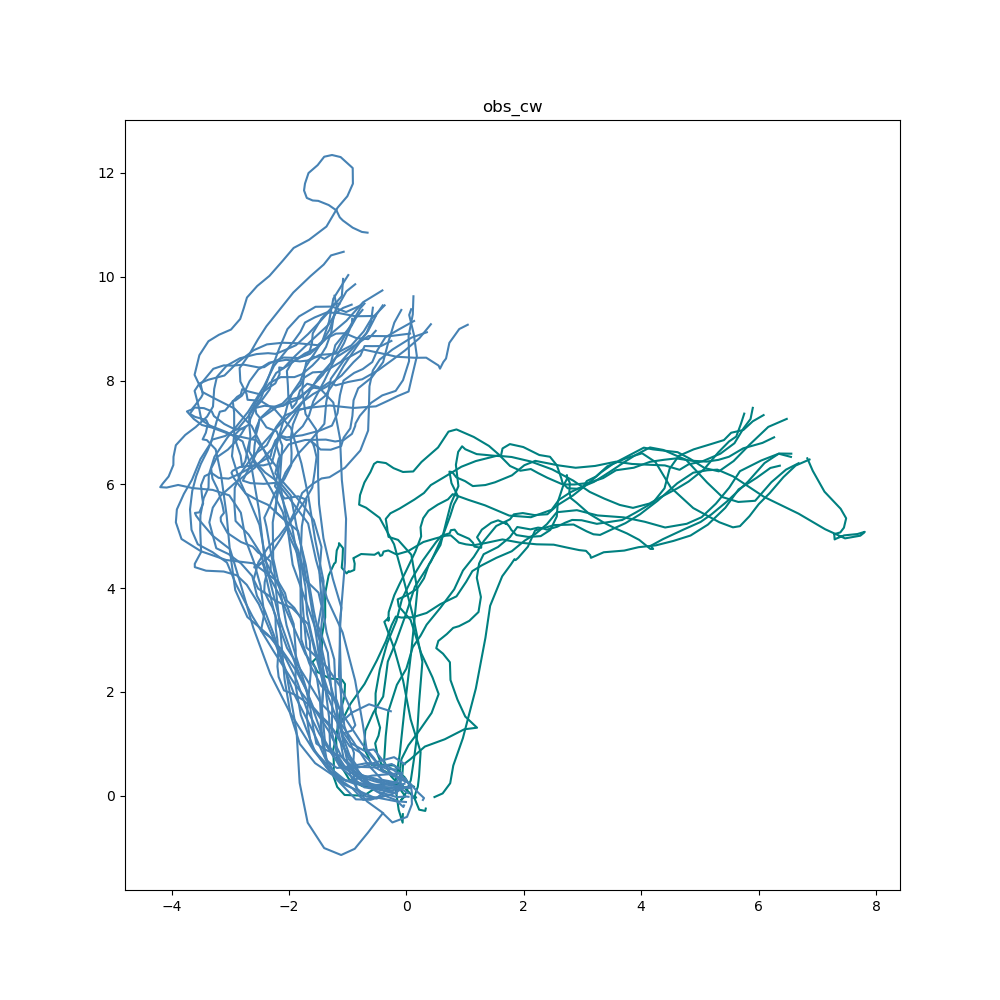

In [5]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

4704     115.0
4755     116.0
4796     117.0
4842     118.0
4890     119.0
4941     120.0
4988     121.0
5046     122.0
5122     123.0
5392     127.0
10206    238.0
Name: trial_global, dtype: float64


<IPython.core.display.Javascript object>


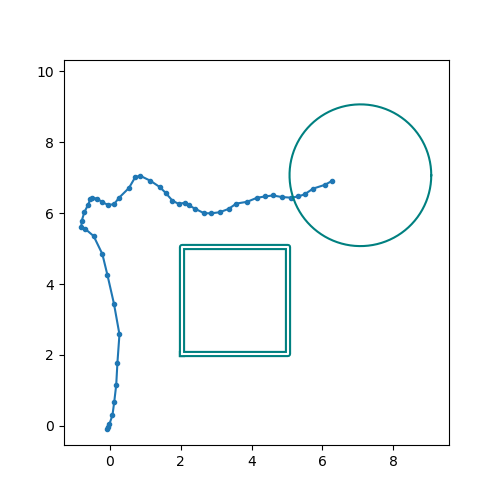

(-1.3012247717787875,
 9.564986506324725,
 -0.5427594616898825,
 10.32345181641363)

In [6]:
target = 4
sel_target = (df['target']==target)
sel_start = (df['bin']==0)
sel_task = (df['task_rot']==1.2) #1.2 is clockwise, 1.1 is counterclockwise
sel = sel_target&sel_start&sel_task
trials = df.loc[sel,'trial_global']
print(trials)

trial = int(trials.iloc[0])
sel_trial = (df['trial_global']==trial)
sel_bin = (df['bin']>=0)
sel = sel_trial&sel_bin

x = df.loc[sel, 'kin_px']
y = df.loc[sel, 'kin_py']

plt.figure(figsize=(5,5))
plt.plot(x,y, '.-')
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
bmi_util.plot_targets(target_pos[target,:].reshape((1,-1)), [c], target_r_task[1]*np.ones(1))
plt.axis('square')

### Load noiseless lqr sim data

In [9]:
save_path = os.path.join(save_dir, 'lqr_noiseless.pkl')
with open(save_path, 'rb') as f: 
    r = pickle.load(f)
#Note the simulations were run with neural activity initialized to 0    
for (k,v) in r.items():
    exec(k+'=v')

<IPython.core.display.Javascript object>


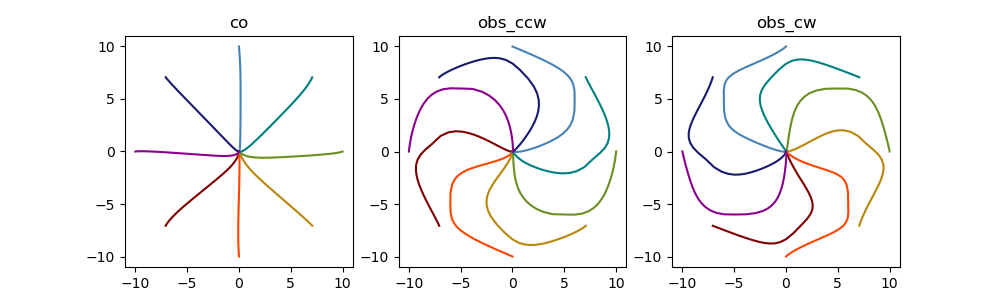

In [10]:
#Plot cw vs ccw trials, to confirm: 
m = 'n_do'
plot = {}
plot['size'] = (10,3)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']


plt.figure(figsize=plot['size'])
for i,task in enumerate(task_rot_list): 
    plt.subplot(1,3,i+1)
    plt.title(task_rot_label[i])    
    for target in range(num_targets):    
        sel = (df_lqr['task_rot']==task) & (df_lqr['bin']>=0) & (df_lqr['target']==target) & (df_lqr['model'] == m)
        df_sel = df_lqr[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.where(df_sel['bin_end']==0)[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
#             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
            color = target_color[target]
            plt.plot(x,y,'-',color=color)

### Compare covariance of expt data and sim data

In [11]:
n_list = ['n_'+str(i) for i in range(num_neurons)]

In [12]:
sel = df['bin']>=0
n_cov = np.cov(np.array(df.loc[sel,n_list]).T)

In [13]:
m = 'n_do'
sel = (df_lqr['bin']>=0)&(df_lqr['model']==m)
n_sim_cov = np.cov(np.array(df_lqr.loc[sel,n_list]).T)    

print(np.diag(n_sim_cov))


[6.02122897e-02 6.68692798e-03 1.34941295e-01 2.09459362e-02
 1.13484700e-01 2.13330829e-01 7.83646198e-02 5.21753360e-03
 2.12916660e-01 8.15412635e-02 2.71375392e-02 1.02764516e-01
 3.90134993e-04 4.96537266e-03 9.55538922e-02 1.15654360e-01
 1.29446106e-02 2.24855425e-02 4.79148080e-02 1.20361275e-02
 1.70396195e-02 6.35527468e-02 7.90240824e-02 8.29248895e-02
 4.21301315e-02 9.68418628e-03 6.53150875e-02 2.21128663e-01
 2.79049178e-02 1.53787829e-02 4.44830015e-02 1.51950512e-01
 2.22061062e-01 7.32876367e-02 5.82046407e-02 2.28805435e-01
 9.35616317e-01 5.66719376e-01 2.89978656e+00 3.70891021e-01
 2.34137702e+00 4.56821574e+00 1.51568991e-01 4.57593191e-02]


<IPython.core.display.Javascript object>


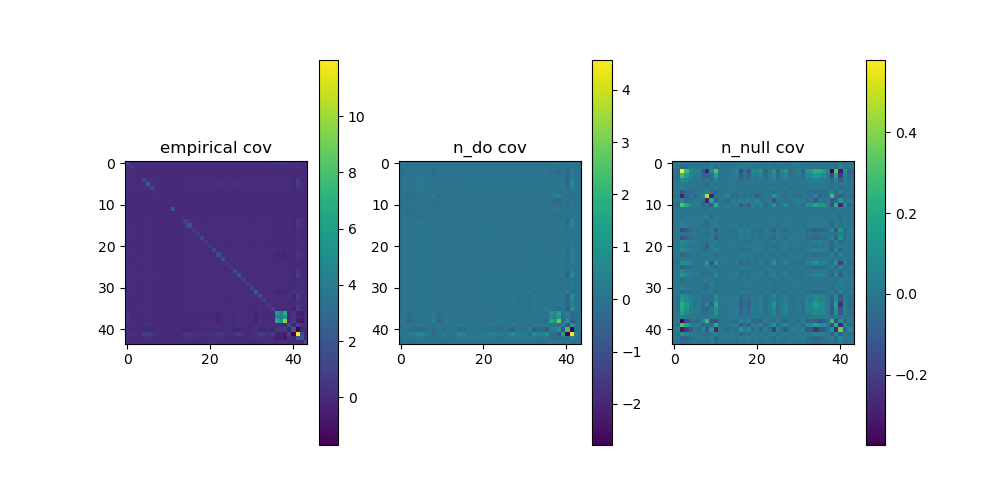

In [14]:
model_plot = ['n_do', 'n_null']
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(n_cov)
plt.title('empirical cov')
plt.colorbar()

sim_cov_dic = {}

for i,m in enumerate(model_plot):
    plt.subplot(1,3,i+2)
    sel = (df_lqr['bin']>=0)&(df_lqr['model']==m)
    n_sim_cov = np.cov(np.array(df_lqr.loc[sel,n_list]).T)    
    sim_cov_dic[m] = n_sim_cov
    
    plt.imshow(n_sim_cov)
    plt.title(m + ' cov')
    plt.colorbar()

<IPython.core.display.Javascript object>


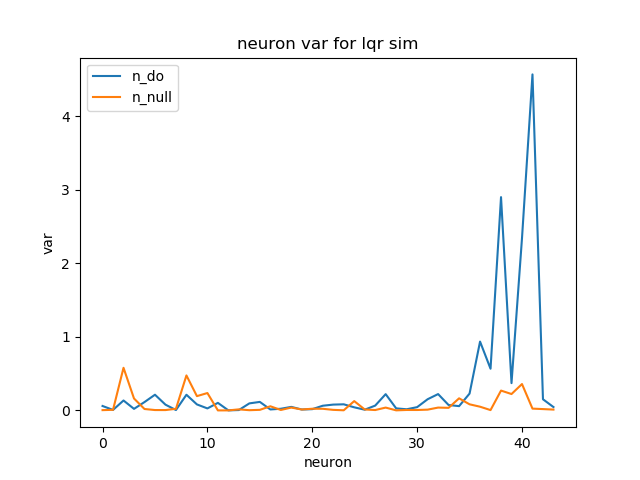

In [15]:
plt.figure()
for m in model_plot:
    var_m = np.diag(sim_cov_dic[m])
    plt.plot(var_m, label=m)
plt.title('neuron var for lqr sim')
plt.xlabel('neuron')
plt.ylabel('var')
plt.legend()

In [16]:
### Load: the psth:
load_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\psth'
load_path = os.path.join(load_dir, 'psth.pkl')
with open(load_path, 'rb') as f: 
    r_psth = pickle.load(f)

<IPython.core.display.Javascript object>


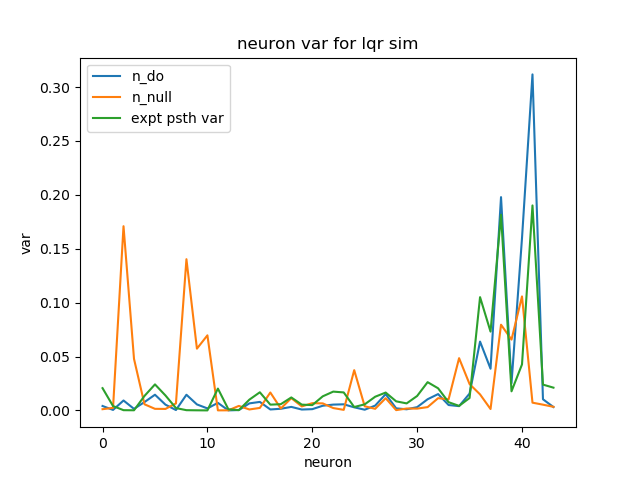

<IPython.core.display.Javascript object>


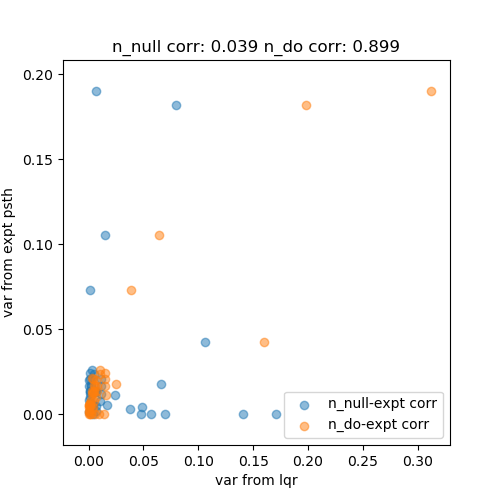

Text(0.5,1,'n_null corr: 0.039 n_do corr: 0.899')

In [17]:
#Compare the variance of neural data in the lqr simulation and in the experiment: 
plt.figure()
for m in model_plot:
    var_m = np.diag(sim_cov_dic[m])
    plt.plot(var_m/sum(var_m), label=m)
plt.plot(r_psth['psth_var']/sum(r_psth['psth_var']), label='expt psth var')
plt.title('neuron var for lqr sim')
plt.xlabel('neuron')
plt.ylabel('var')
plt.legend()


expt = r_psth['psth_var']/sum(r_psth['psth_var'])

m='n_do'
n_do = np.diag(sim_cov_dic[m])
n_do = n_do/sum(n_do)

m='n_null'
n_null = np.diag(sim_cov_dic[m])
n_null = n_null/sum(n_null)

plt.figure(figsize=(5,5))
plt.scatter(n_null, expt, label='n_null-expt corr',alpha=0.5)
plt.scatter(n_do, expt, label='n_do-expt corr', alpha=0.5)
plt.xlabel('var from lqr')
plt.ylabel('var from expt psth')
plt.legend()

null_expt_corr = round(np.corrcoef(n_null, expt)[0,1],3)
do_expt_corr = round(np.corrcoef(n_do, expt)[0,1],3)

np.corrcoef(n_do, expt)
plt.title('n_null corr: ' + str(null_expt_corr) + ' n_do corr: ' + str(do_expt_corr))

In [18]:
#Solve for the noise for each model: 
for m in model_plot: 
    sim_cov_dic[m,'diag'] = np.diag(sim_cov_dic[m])
    sim_cov_dic[m,'noise'] = sim_cov_dic[m,'diag']/r_psth['snr']
    sim_cov_dic[m,'snr'] = sim_cov_dic[m,'diag']/sim_cov_dic[m,'noise']


<IPython.core.display.Javascript object>


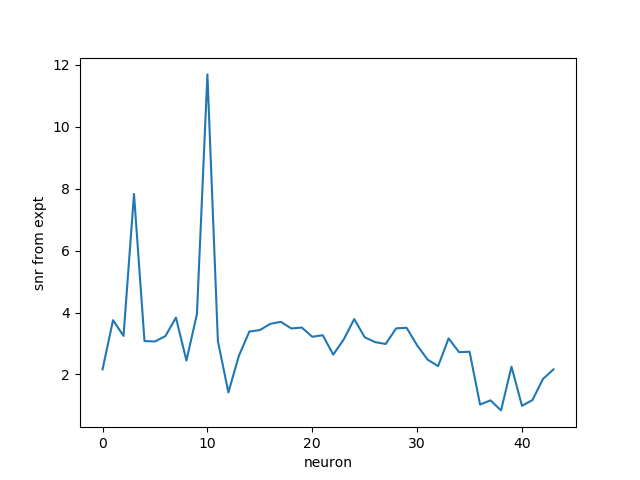

<IPython.core.display.Javascript object>


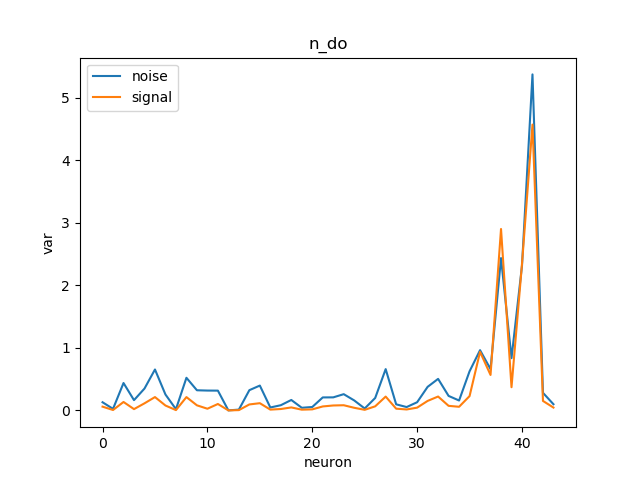

<IPython.core.display.Javascript object>


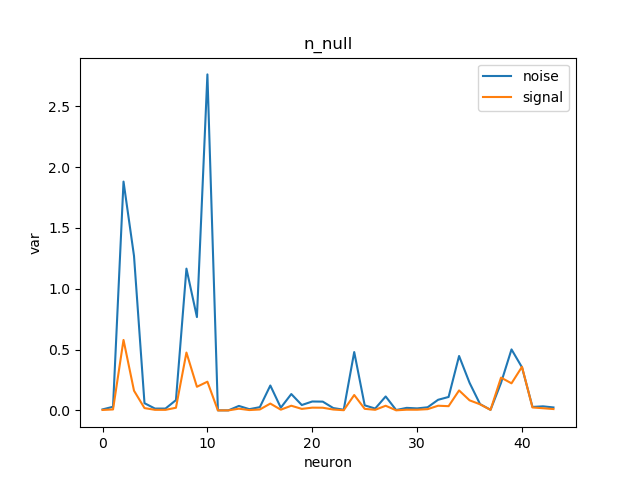

<IPython.core.display.Javascript object>


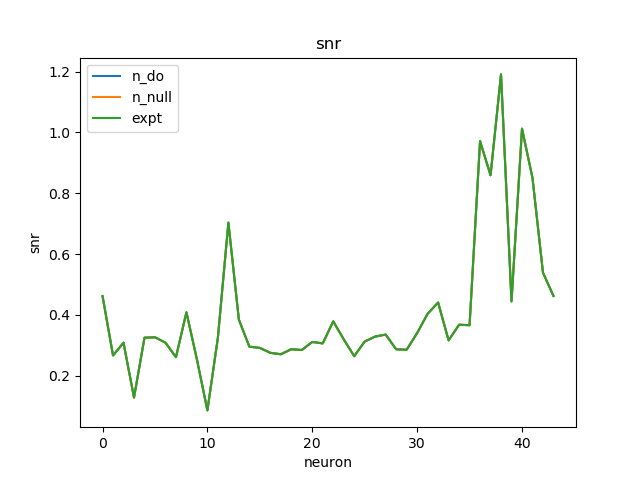

Text(0.5,1,'snr')

In [19]:

plt.figure()
plt.plot(1/r_psth['snr'])
plt.xlabel('neuron')
plt.ylabel('snr from expt')


for m in model_plot:
    plt.figure()
    plt.plot(sim_cov_dic[m,'noise'], label='noise')
    plt.plot(sim_cov_dic[m,'diag'], label='signal')
    plt.legend()
    plt.xlabel('neuron')
    plt.ylabel('var')
    plt.title(m)
    
    
plt.figure()
for m in model_plot:
    plt.plot(sim_cov_dic[m,'snr'], label=m)
plt.plot(r_psth['snr'], label='expt')
plt.legend()
plt.xlabel('neuron')
plt.ylabel('snr')
plt.title('snr')


In [20]:
sim_cov_dic[m,'noise']

masked_array(data=[8.34614768e-03, 2.99939152e-02, 1.88053455e+00,
                   1.26963837e+00, 5.93673047e-02, 1.51974024e-02,
                   1.52748544e-02, 8.45789163e-02, 1.16519127e+00,
                   7.67171093e-01, 2.76141108e+00, 5.62353968e-04,
                   4.06194401e-04, 3.69511044e-02, 1.02115743e-02,
                   2.69077384e-02, 2.04798418e-01, 2.25088064e-02,
                   1.34596533e-01, 4.43225670e-02, 7.33494907e-02,
                   7.22528511e-02, 1.95919076e-02, 5.50496013e-03,
                   4.79793920e-01, 4.17177483e-02, 1.54698695e-02,
                   1.14705720e-01, 3.14437022e-03, 2.09442741e-02,
                   1.66617364e-02, 2.58526731e-02, 8.74013757e-02,
                   1.10595603e-01, 4.47315403e-01, 2.26691575e-01,
                   5.18611017e-02, 5.08897207e-03, 2.26333016e-01,
                   5.01342379e-01, 3.54100005e-01, 2.86279538e-02,
                   3.35442349e-02, 2.44553743e-02],
          

<IPython.core.display.Javascript object>


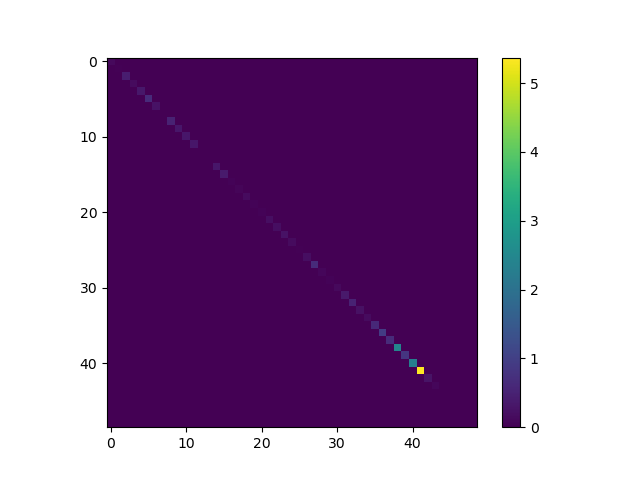

<IPython.core.display.Javascript object>


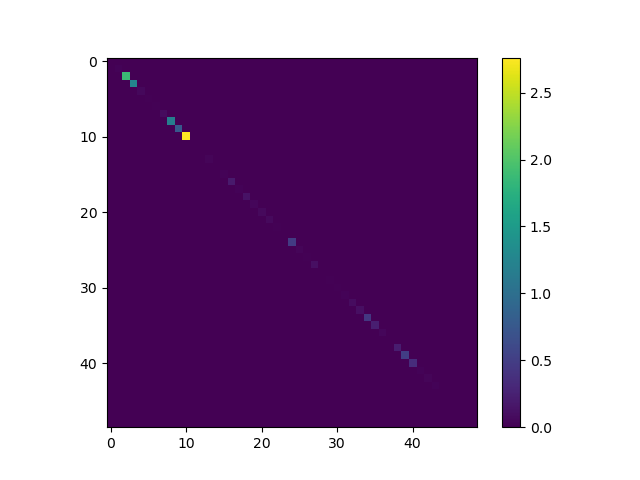

In [23]:
#DEFINE NOISE DICTIONARY: 

state_dim = num_neurons+len(kin_var)+len(offset_var)
noise_dic = {}
for m in model_plot:
    state_noise_mean = np.zeros(state_dim)
    state_noise_cov = np.zeros((state_dim, state_dim)) #np.eye(state_dim)*0.5
    state_noise_cov[:num_neurons,:num_neurons] = np.diag(np.array(sim_cov_dic[m,'noise']))
#     state_noise_cov[:num_neurons,:num_neurons] = np.diag(np.array(sim_cov_dic['n_do','noise']))
    state_noise_cov[num_neurons:, num_neurons:] = 0
    
    noise_dic[m, 'state_noise_mean'] = state_noise_mean
    noise_dic[m, 'state_noise_cov'] = state_noise_cov

plt.figure()
plt.imshow(noise_dic['n_do', 'state_noise_cov'])
plt.colorbar()

plt.figure()
plt.imshow(noise_dic['n_null', 'state_noise_cov'])
plt.colorbar()    

In [24]:
#Define Models for each movement
#For each movement:
#Define number of segments, number of 
n_list = ['n_'+str(i) for i in range(num_neurons)]

move_horizon = 39
model_list = ['n_do', 'n_null'] #'n_o',
input_label = n_list

target_list = range(num_targets)
task_rot_list = [0,1.1,1.2]
center = np.array([0,0])
#waypoint parameters:
obs_margin = 6
waypoint_speed = 10

#This does movement simulation too!  
n_init_sel = np.zeros(len(n_init)) #n_init

num_trials = 20
t_start = timeit.default_timer()
move_lqr = bmi_b.sim_lqr_move_noise(\
    num_trials, move_horizon, model_list, A_dic, B, Q, R, Q_f, noise_dic,\
    target_list, task_rot_list, center, target_pos, obs_pos, n_init_sel, obs_margin, waypoint_speed,\
    state_label, state_dim, input_label, num_neurons, hold_req=2, target_r=1.7)
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)


28.5111684


### Above takes some time...

<IPython.core.display.Javascript object>


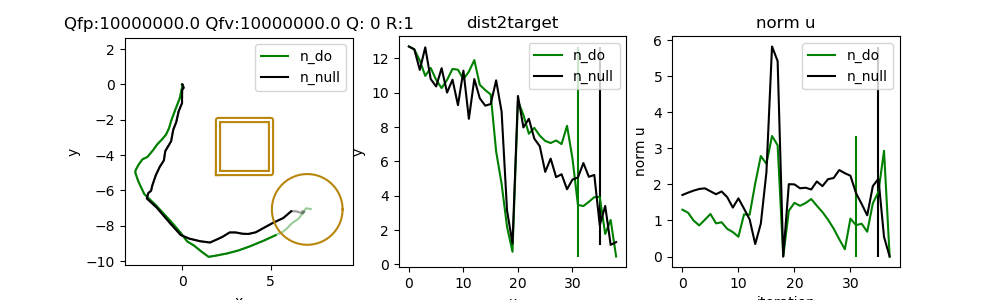

In [25]:
#Visualize: 

#Show diagnostics for the example: 

#Plot each on the same subplot
#Visualize results: 
trial = 4
target = 2
task = 1.1 #1.2
horizon_list = move_lqr[target,task,'n_do']['horizon_list']


#hardcoded:
if task >0:
    num_seg = 2
else:
    num_seg = 1    
if task == 0: 
    seg_x = np.array([[0], [horizon_list[0]]])
else:
    seg_x = np.array([[0, horizon_list[0]], [horizon_list[0]-1, sum(horizon_list)-2]])

state_T_list = move_lqr[target,task,m]['state_T_list']
state_T_mat = np.array(state_T_list).squeeze().T
if task==0:
    state_T_mat = state_T_mat.reshape((-1,1))
state_T_da = xr.DataArray(state_T_mat, coords={'v':n_list+kin_var+offset_var, 'seg':range(num_seg)},\
                           dims=['v', 'seg'])    
    


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}

model_list = ['n_do', 'n_null'] #'n_o'
plt.figure(figsize=(10,3))
#------------------------------------------------------------------
#CURSOR PLOTS:
plt.subplot(1,3,1)
for i,m in enumerate(model_list): #enumerate(task_models[task]):
    state_da = move_lqr[target,task,m]['state_list'][trial]
    sim_len = move_lqr[target,task,m]['sim_len']
    
    
    x = state_da.loc['kin_px',:]
    y = state_da.loc['kin_py',:]        
    plt.plot(x,y,'-', alpha=0.4, color=model_color[m]) # label=k
    
    x = state_da.loc['kin_px',np.arange(0,sim_len)]
    y = state_da.loc['kin_py',np.arange(0,sim_len)]
    plt.plot(x,y,'-', label=m, color=model_color[m])

bmi_util.plot_targets(target_pos[target:target+1,:], target_color[target:target+1], target_r_task[1]*np.ones(1)) 
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
plt.axis('square')    
plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('Qfp:' + str(Qfp_s) + ' Qfv:' + str(Qfv_s) + ' Q: ' + str(Qp_s) + ' R:' + str(R_s))  

#------------------------------------------------------------------
#Dist2Target PLOTS:
#Let's modify this to subtract the segment's goal, to verify targets are being met.

    
plt.subplot(1,3,2)
for i,m in enumerate(model_list): #for i,m in enumerate(task_models[task]):       
#     e_da = move_lqr[target,task,m]['state_e_da'].loc[['kin_px', 'kin_py'],:]
    e_a = \
        move_lqr[target,task,m]['state_list'][trial].loc[kin_var,:]
    for seg in range(num_seg):
        e_a.loc[:,seg_x[0,seg]:seg_x[1,seg]] = e_a.loc[:,seg_x[0,seg]:seg_x[1,seg]] - \
            state_T_da.loc[kin_var,seg]
    norm_e_a = np.linalg.norm(e_a,axis=0)
    
    sim_len = move_lqr[target,task,m]['sim_len']
    norm_e = np.linalg.norm(e_a,axis=0)
    plt.plot(norm_e_a,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_e_a.min(), norm_e_a.max(), color=model_color[m]) #label=k+' done!'

plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('dist2target')     

#------------------------------------------------------------------
#INPUT PLOTS:
plt.subplot(1,3,3)
# for i,m in enumerate(task_models[task]):
for i,m in enumerate(model_list):    
    u_da = move_lqr[target,task,m]['u_list'][trial]
    sim_len = move_lqr[target,task,m]['sim_len']
    norm_u = np.linalg.norm(u_da,axis=0)
    plt.plot(norm_u,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_u.min(), norm_u.max(), color=model_color[m]) #label=k+' done!'
plt.xlabel('iteration')
plt.ylabel('norm u')
plt.title('norm u')
plt.legend()



In [26]:
num_trials

20

In [28]:
#Collect norm_u results: 
columns = ['norm_u', 'target', 'task', 'model']
num_col = len(columns)
nan_df = pd.DataFrame(np.ones((1,num_col))*np.nan, columns=columns)
df_list = []
for target in target_list:
    for task in task_rot_list:
        for m in model_list:
            df_i = copy.deepcopy(nan_df)
            
            
            df_i['target'] = target
            df_i['task'] = task
            df_i['model'] = m            
            df_i['norm_u'] = 0
            
            for trial in range(num_trials):
                df_i['norm_u'] += np.linalg.norm(move_lqr[target,task,m]['u_list'][trial])
            df_i['norm_u'] = df_i['norm_u']/num_trials
            
            df_list.append(df_i)
lqr_df = pd.concat(df_list, ignore_index=True)

<IPython.core.display.Javascript object>


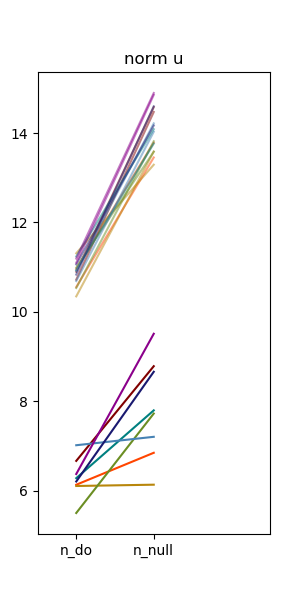

(-0.5, 2.5)

In [29]:
#Plot norm u for all movements: 
# model_list = ['n_do', 'n_o', 'n_null']
model_list = ['n_do', 'n_null']
task_alpha = {0:1, 1.1:0.5, 1.2:0.5}
plt.figure(figsize=(3,6))
for target in target_list:
    for task in task_rot_list:
        
        x_plot = []
        y_plot = []
        for i,m in enumerate(model_list):
            x_plot.append(i)
            sel = \
            (lqr_df['target']==target)\
            &(lqr_df['task']==task)\
            &(lqr_df['model']==m)
            y_i = float(lqr_df.loc[sel,'norm_u'])
            y_plot.append(y_i)
            
        plt.plot(x_plot,y_plot,color=target_color[target], alpha=task_alpha[task]) #label='target'+str(target)+'task'+str(task)

plt.xticks(range(len(model_list)), model_list)
plt.ylabel('norm u')
plt.title('norm u')
plt.xlim([-0.5,2.5])

In [ ]:
#TODO:
#Then later we need to add a number of trials

### Collect the movements into a results df

In [31]:
u_list = ['u_' + str(i) for i in range(num_neurons)]
decode_var = ['u_px', 'u_py', 'u_vx', 'u_vy', 'u_offset']
Kn_m = np.mat(Kn)

target = 2
task = 1.1 
m = 'n_null'
move_len = move_lqr[target,task,m]['move_len']

df_list = []

lqr_var = ['model']
task_var = ['task_rot', 'target', 'bin', 'bin_end', 'trial']
lqr_df_var = n_list+kin_var+decode_var+u_list+task_var+lqr_var
num_col = len(lqr_df_var)


for target in target_list:
    for task in task_rot_list:
        for m in model_list:
            for trial in range(num_trials):
                #n_list, kin_var:
                state_da = move_lqr[target,task,m]['state_list'][trial]
                #input:
                u_da = xr.DataArray(np.zeros((num_neurons,move_len)), coords={'v':u_list, 'obs':range(move_len)}, dims=['v', 'obs'])
                u_da.loc[:,0:(move_len-2)]=np.array(move_lqr[target,task,m]['u_list'][trial]) #append a zeros to the end of it so it's the same size as state_da
                #decode_var:
                n2k = Kn_m*state_da.loc[n_list,:]
                n2k_da = xr.DataArray(n2k, coords={'v':decode_var, 'obs':range(move_len)}, dims=['v', 'obs'])

                #ASSIGN:
                df_i = pd.DataFrame(pd.DataFrame(np.ones((move_len,num_col))*np.nan, columns=lqr_df_var))
                #n_list, kin_var, decode_var, u_list
                df_i.loc[:,n_list] = state_da.loc[n_list,:].T
                df_i.loc[:,kin_var] = state_da.loc[kin_var,:].T
                df_i.loc[:,decode_var] = n2k_da.T            
                df_i.loc[:,u_list] = u_da.T
                #Task-related data:
                df_i.loc[:,'model'] = m
                df_i.loc[:,'task_rot'] = task
                df_i.loc[:,'target'] = target
                df_i.loc[:,'trial'] = 0
                df_i.loc[:,'bin'] = range(move_len)
                df_i.loc[:,'bin_end'] = range(move_len-1,-1,-1)

                df_list.append(df_i)
df_lqr = pd.concat(df_list, ignore_index=True)

In [32]:
df_lqr.shape

(37440, 103)

In [33]:
#Preprocess: 
#-------------------------------------------------------------------------------------------------
bmi_b.df_bmi_cartesian2polar(df_lqr)
#-------------------------------------------------------------------------------------------------

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8

#-------------------------------------------------------------------------------------------------
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df_lqr, mag_bin_perc, num_angle_bins, T0_angle)
#-------------------------------------------------------------------------------------------------


#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df_lqr, angle_bin)
#Then preprocess to get angles: 
bmi_b.df_bin_command(df_lqr, mag_bin_edges,angle_bin_edges)
# #Center angles to command bin, target: 
bmi_b.center_df_angle(df_lqr, angle_bin_c, target_angle)



('angle_center:', 22.5)
('min centered angle:', -157.4806907872773)
('max centered angle:', 202.49245555995128)


<IPython.core.display.Javascript object>


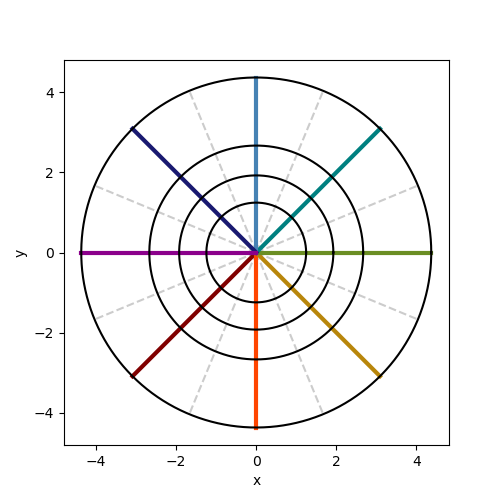

In [34]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)
    
plt.figure(figsize=(5,5))
plot_command_bin()    

<IPython.core.display.Javascript object>


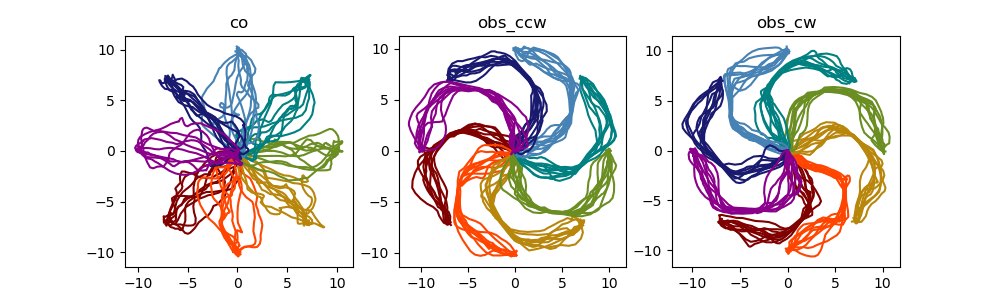

In [35]:
#Plot cw vs ccw trials, to confirm: 
m = 'n_do'#'n_null'
plot = {}
plot['size'] = (10,3)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']


num_trials_plot = 10
plt.figure(figsize=plot['size'])
for i,task in enumerate(task_rot_list): 
    plt.subplot(1,3,i+1)
    plt.title(task_rot_label[i])    
    for target in range(num_targets):    
        sel = (df_lqr['task_rot']==task) & (df_lqr['bin']>=0) & (df_lqr['target']==target) & (df_lqr['model'] == m)
        df_sel = df_lqr[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.where(df_sel['bin_end']==0)[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:num_trials_plot,:]: #trial_bound[0:1,:]:
#             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
            color = target_color[target]
            plt.plot(x,y,'-',color=color)

### Analyze the df: 

In [36]:
#Calculate for each bin the average activity: 
#Then ... for each model, calc command_move_mean - move_mean. 
#to start, we ask if pooling already shows a difference.
model_list = ['n_do', 'n_o', 'n_null']

#command mean: diff, ang, mag, model
df_mean_col = n_list + ['ba', 'bm', 'model', 'num']
nan_df = pd.DataFrame()
df_mean = []
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            sel = sel_ba&sel_bm&sel_m
            n_i = df_lqr.loc[sel,n_list].mean()
            
            
            df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_mean_col)))*np.nan, columns=df_mean_col))
            df_i.loc[0,n_list]=n_i
            df_i['ba'] = ba
            df_i['bm'] = bm
            df_i['model'] = m
            df_i['num'] = len(np.where(sel)[0])
            df_mean.append(df_i)
df_mean = pd.concat(df_mean, ignore_index=True)        

                      

In [37]:
#mean diff: 
df_diff_col = n_list + ['diff', 'diff_null', 'diff_potent', 'ba', 'bm', 'model', 'target', 'task_rot', 'num']
nan_df = pd.DataFrame()
df_diff = []
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    sel_d_ba = (df_mean['ba'] == ba)    
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        sel_d_bm = (df_mean['bm'] == bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            sel_d_m = (df_mean['model'] == m)
            sel_d = sel_d_ba&sel_d_bm&sel_d_m
            mean_i = df_mean.loc[sel_d, n_list]
            
            
            for task in task_rot_list:
                sel_task = (df_lqr['task_rot']==task)
                for target in range(num_targets):
                    sel_target = (df_lqr['target']==target)
                    
                    sel = sel_ba&sel_bm&sel_m&sel_task&sel_target
                    num = len(np.where(sel)[0])
                    if num > 0:
                        n_i = df_lqr.loc[sel,n_list].mean()
                        diff_i = n_i-mean_i
                        diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                        
                        df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_diff_col)))*np.nan, columns=df_diff_col))
                        df_i.loc[0,n_list]=n_i
                        df_i['diff']=np.linalg.norm(diff_i)
                        df_i['diff_null']=np.linalg.norm(diff_null_i)
                        df_i['diff_potent']=np.linalg.norm(diff_potent_i)
                        df_i['ba'] = ba
                        df_i['bm'] = bm
                        df_i['model'] = m
                        df_i['task_rot'] = task
                        df_i['target'] = target
                        df_i['num'] = num

                        df_diff.append(df_i)
df_diff = pd.concat(df_diff, ignore_index=True)   

<IPython.core.display.Javascript object>


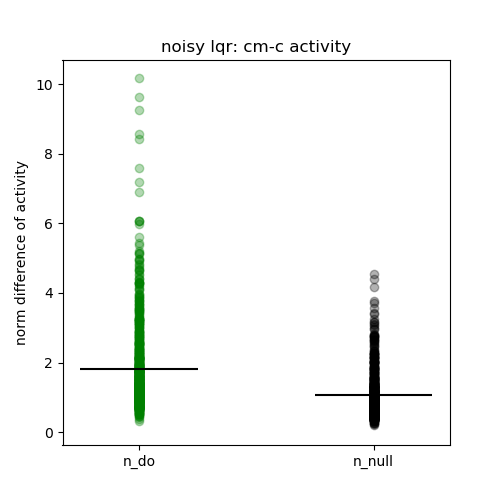

n_do
('n_do', 1.826291221121346)
n_null
('n_null', 1.052627299767436)


Text(0,0.5,'norm difference of activity')

In [39]:
plt.figure(figsize=(5,5))

model_list = ['n_do', 'n_null']
model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}
d_cm_diff = []


min_obs = 1
for i,m in enumerate(model_list):
    print(m)
    sel_m = df_diff['model']==m
    sel_obs = df_diff['num']>=min_obs
    
    sel = sel_m&sel_obs
#     sel = sel_m&sel_obs
    diff_i = df_diff.loc[sel, 'diff']
    d_cm_diff.append(diff_i)
    diff_mean_i = df_diff.loc[sel, 'diff'].mean()
    print(m, diff_mean_i)
#     num = df_diff.loc[sel, 'num'].mean()
#     print(m, test, num)
    plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3,color=model_color[m])
    plt.hlines(diff_mean_i, i-0.25,i+0.25)
    
_=plt.xticks([0,1], model_list)
plt.title('noisy lqr: cm-c activity')
plt.ylabel('norm difference of activity')

c:\anaconda3\envs\py2\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


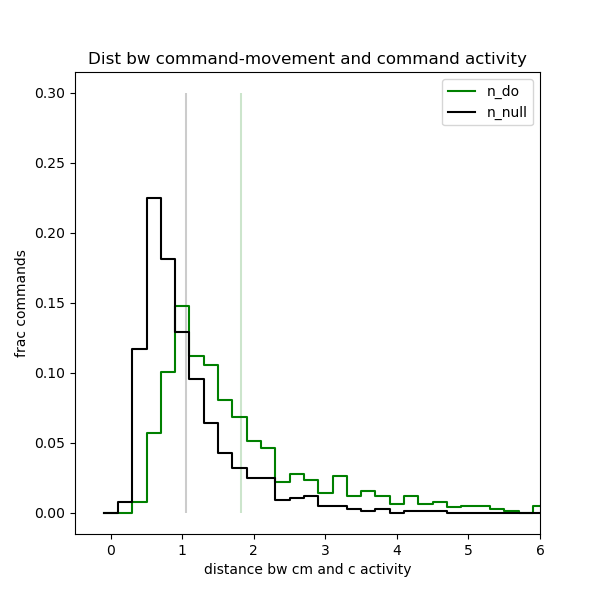

61
(124L,)
61
(124L,)


Text(0.5,1,'Dist bw command-movement and command activity')

In [40]:
#Histogram the diffs and plot overlapping distributions:
vmin = 0
vmax = 12
num_bins = (vmax-vmin)*5+1
cm_diff_bins_c = np.linspace(vmin,vmax,num_bins)
bin_w = cm_diff_bins_c[1]-cm_diff_bins_c[0]
cm_diff_bins_e = np.vstack((cm_diff_bins_c-bin_w/2, cm_diff_bins_c+bin_w/2))
bin_dic = {0:cm_diff_bins_e}

cm_diff_binned = []
for i,d in enumerate(d_cm_diff):
    d = np.array(d).reshape((-1,1))
    bin_result, hist_result = bmi_b.bin_vec_data(d,bin_dic)
    cm_diff_binned.append(hist_result)


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}    
cm_diff_bins_e_flat = np.hstack((cm_diff_bins_e[0,:], cm_diff_bins_e[1,-1]))

plt.figure(figsize=(6,6))
for i,d in enumerate(cm_diff_binned):
    m = model_list[i]
    d_plot = d/np.sum(d)
#     d_plot = np.cumsum(d_plot)
    bmi_util.hist_step_plot(cm_diff_bins_e_flat, d_plot,color=model_color[m],label=m)
    
    d_mean = np.mean(d_cm_diff[i])
    plt.vlines(d_mean, 0, 0.3, color=model_color[m],alpha=0.2)
plt.xlim((-0.5,6))    
plt.legend()    
plt.xlabel('distance bw cm and c activity')
plt.ylabel('frac commands')
plt.title('Dist bw command-movement and command activity')


<IPython.core.display.Javascript object>


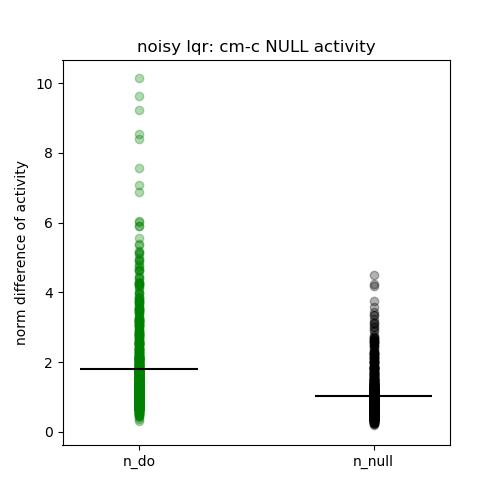

n_do
('n_do', 1.8115091687321296)
n_null
('n_null', 1.022934759874576)


Text(0,0.5,'norm difference of activity')

In [41]:
plt.figure(figsize=(5,5))

model_list = ['n_do', 'n_null']
model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}
d_cm_diff = []


min_obs = 1
for i,m in enumerate(model_list):
    print(m)
    sel_m = df_diff['model']==m
    sel_obs = df_diff['num']>=min_obs
    
    sel = sel_m&sel_obs
#     sel = sel_m&sel_obs
    diff_i = df_diff.loc[sel, 'diff_null']
    d_cm_diff.append(diff_i)
    diff_mean_i = df_diff.loc[sel, 'diff_null'].mean()
    print(m, diff_mean_i)
#     num = df_diff.loc[sel, 'num'].mean()
#     print(m, test, num)
    plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3,color=model_color[m])
    plt.hlines(diff_mean_i, i-0.25,i+0.25)
    
_=plt.xticks([0,1], model_list)
plt.title('noisy lqr: cm-c NULL activity')
plt.ylabel('norm difference of activity')

<IPython.core.display.Javascript object>


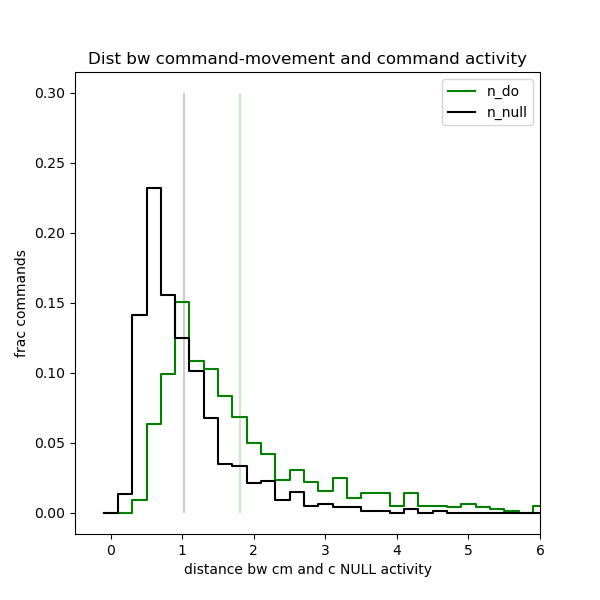

61
(124L,)
61
(124L,)


Text(0.5,1,'Dist bw command-movement and command activity')

In [42]:
#Histogram the diffs and plot overlapping distributions:
vmin = 0
vmax = 12
num_bins = (vmax-vmin)*5+1
cm_diff_bins_c = np.linspace(vmin,vmax,num_bins)
bin_w = cm_diff_bins_c[1]-cm_diff_bins_c[0]
cm_diff_bins_e = np.vstack((cm_diff_bins_c-bin_w/2, cm_diff_bins_c+bin_w/2))
bin_dic = {0:cm_diff_bins_e}

cm_diff_binned = []
for i,d in enumerate(d_cm_diff):
    d = np.array(d).reshape((-1,1))
    bin_result, hist_result = bmi_b.bin_vec_data(d,bin_dic)
    cm_diff_binned.append(hist_result)


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}    
cm_diff_bins_e_flat = np.hstack((cm_diff_bins_e[0,:], cm_diff_bins_e[1,-1]))

plt.figure(figsize=(6,6))
for i,d in enumerate(cm_diff_binned):
    m = model_list[i]
    d_plot = d/np.sum(d)
#     d_plot = np.cumsum(d_plot)
    bmi_util.hist_step_plot(cm_diff_bins_e_flat, d_plot,color=model_color[m],label=m)
    
    d_mean = np.mean(d_cm_diff[i])
    plt.vlines(d_mean, 0, 0.3, color=model_color[m],alpha=0.2)
plt.xlim((-0.5,6))    
plt.legend()    
plt.xlabel('distance bw cm and c NULL activity')
plt.ylabel('frac commands')
plt.title('Dist bw command-movement and command activity')


<IPython.core.display.Javascript object>


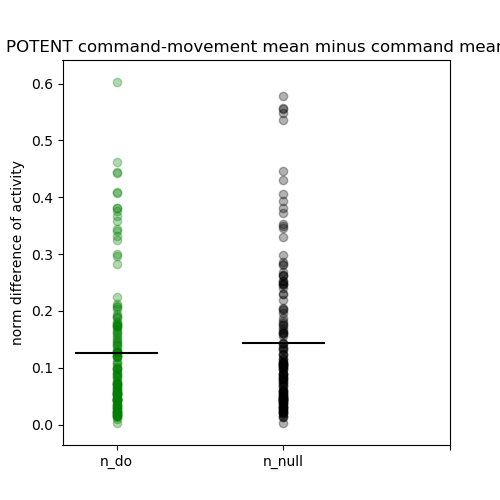

Text(0,0.5,'norm difference of activity')

In [43]:

plt.figure(figsize=(5,5))

min_obs = 40
for i,m in enumerate(model_list):
    sel_m = df_diff['model']==m
    sel_obs = df_diff['num']>=min_obs
    
    sel = sel_m&sel_obs
#     sel = sel_m&sel_obs
    diff_i = df_diff.loc[sel, 'diff_potent']
    diff_mean_i = df_diff.loc[sel, 'diff_potent'].mean()
#     num = df_diff.loc[sel, 'num'].mean()
#     print(m, test, num)
    plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3,color=model_color[m])
    plt.hlines(diff_mean_i, i-0.25,i+0.25)
    
_=plt.xticks([0,1,2], model_list)
plt.title('POTENT command-movement mean minus command mean')
plt.ylabel('norm difference of activity')
    

In [44]:
#Print out mean differences: 
sel_command =False
ba = 1
bm = 0
min_obs = 1

for i,m in enumerate(model_list):
    sel_m = df_diff['model']==m
    sel_obs = df_diff['num']>=min_obs
    sel_ba = df_diff['ba']==ba
    sel_bm = df_diff['bm']==bm
    
    if sel_command:
        sel = sel_m&sel_obs&sel_ba&sel_bm
    else:
        sel = sel_m&sel_obs
    test = df_diff.loc[sel, 'diff'].mean()
    num = df_diff.loc[sel, 'num'].mean()
    print(m, test, num)

('n_do', 1.826291221121346, 23.38573315719947)
('n_null', 1.052627299767436, 23.82)


### Check how predictable neural activity is

### Dynamics model, use A

In [48]:
m = 'n_do'

sel_m = (df_lqr['model']==m)

sel_t_bin = (df_lqr['bin'] >= 0)
sel_t_bin_end = (df_lqr['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)&sel_m
n_t = np.array(df_lqr.loc[sel_t,n_list]).T

sel_tp1_bin = (df_lqr['bin'] >= 1)
sel_tp1_bin_end = (df_lqr['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)&sel_m
n_tp1 = np.array(df_lqr.loc[sel_tp1,n_list]).T

nhat_tp1 = np.dot(An, n_t)+ bn.reshape((-1,1))


#sanity check we can use the dynamics parameters:
total_cov = np.cov(n_tp1)
total_var = np.trace(total_cov)

res_hat = nhat_tp1-n_tp1 #44 x num_obs
res_cov = np.cov(res_hat) #44 x 44
res_var = np.trace(res_cov)

pred_cov = np.cov(nhat_tp1)
pred_var = np.trace(pred_cov)

print('sanity check on neural dynamics fit:')
print('model A R2: ', 1-res_var/total_var)
# print('true R2: ', clf.score(n_t, n_tp1))

sanity check on neural dynamics fit:
('model A R2: ', 0.4187612249289504)


### Dynamics model, fit new A, b

In [49]:
m = 'n_do'

sel_m = (df_lqr['model']==m)

sel_t_bin = (df_lqr['bin'] >= 0)
sel_t_bin_end = (df_lqr['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)&sel_m
n_t = np.array(df_lqr.loc[sel_t,n_list]).T

sel_tp1_bin = (df_lqr['bin'] >= 1)
sel_tp1_bin_end = (df_lqr['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)&sel_m
n_tp1 = np.array(df_lqr.loc[sel_tp1,n_list]).T


# regression: 
#ridge parameter from Preeya: 2500
clf = Ridge(alpha=1)
clf.fit(n_t.T, n_tp1.T)

An_fit = clf.coef_
bn_fit = clf.intercept_

print('fit A R2: ', clf.score(n_t.T, n_tp1.T))

('fit A R2: ', 0.4377016678532682)


### No dynamics model, fit new A, b

In [50]:
m = 'n_null'

sel_m = (df_lqr['model']==m)

sel_t_bin = (df_lqr['bin'] >= 0)
sel_t_bin_end = (df_lqr['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)&sel_m
n_t = np.array(df_lqr.loc[sel_t,n_list]).T

sel_tp1_bin = (df_lqr['bin'] >= 1)
sel_tp1_bin_end = (df_lqr['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)&sel_m
n_tp1 = np.array(df_lqr.loc[sel_tp1,n_list]).T

clf = Ridge(alpha=1)
clf.fit(np.array(n_t).T, np.array(n_tp1).T)

An_fit_null = clf.coef_
bn_fit_null = clf.intercept_

print('fit A R2: ', clf.score(n_t.T, n_tp1.T))

('fit A R2: ', 0.12711729135422023)


In [ ]:
n_t.shape

### Save results: 

In [51]:
move_lqr.keys()

[(7, 1.1, 'n_do'),
 (0, 1.1, 'n_do'),
 (7, 0, 'n_null'),
 (3, 0, 'n_null'),
 (5, 1.1, 'n_do'),
 (3, 1.2, 'n_do'),
 (0, 1.1, 'n_null'),
 (4, 1.2, 'n_null'),
 (3, 1.2, 'n_null'),
 (2, 1.2, 'n_null'),
 (1, 1.2, 'n_null'),
 (4, 1.2, 'n_do'),
 (6, 0, 'n_null'),
 (5, 1.2, 'n_do'),
 (2, 1.1, 'n_null'),
 (1, 1.1, 'n_null'),
 (7, 1.2, 'n_do'),
 (6, 1.1, 'n_do'),
 (2, 0, 'n_null'),
 (4, 1.1, 'n_do'),
 (5, 0, 'n_do'),
 (4, 0, 'n_null'),
 (2, 1.2, 'n_do'),
 (4, 0, 'n_do'),
 (4, 1.1, 'n_null'),
 (0, 0, 'n_null'),
 (6, 1.2, 'n_null'),
 (5, 1.2, 'n_null'),
 (3, 1.1, 'n_null'),
 (7, 0, 'n_do'),
 (0, 0, 'n_do'),
 (6, 1.1, 'n_null'),
 (1, 0, 'n_do'),
 (3, 1.1, 'n_do'),
 (6, 0, 'n_do'),
 (1, 1.1, 'n_do'),
 (7, 1.1, 'n_null'),
 (5, 1.1, 'n_null'),
 (2, 0, 'n_do'),
 (1, 1.2, 'n_do'),
 (0, 1.2, 'n_null'),
 (3, 0, 'n_do'),
 (7, 1.2, 'n_null'),
 (6, 1.2, 'n_do'),
 (5, 0, 'n_null'),
 (2, 1.1, 'n_do'),
 (0, 1.2, 'n_do'),
 (1, 0, 'n_null')]

In [ ]:
len(move_lqr[0,1.1,'n_do']['state_list'])

In [53]:
#Collect results: 
#NOTE: I'm saving the same data multiple times (move_lqr and df_lqr), inefficient
r = {}
r['An'] = An
r['bn'] = bn
r['n_init'] = n_init
r['kin_var'] = kin_var
r['offset_var'] = offset_var
r['F'] = F
r['Kn'] = Kn
r['A_list'] = A_list
r['A_dic'] = A_dic
r['B'] = B
r['Qfp_s'] = Qfp_s
r['Qfv_s'] = Qfv_s
r['Qp_s'] = Qp_s
r['Qv_s'] = Qv_s
r['R_s'] = R_s
r['Q_f'] = Q_f
r['Q'] = Q
r['R'] = R

r['state_dim'] = state_dim
r['noise_dic'] = noise_dic
r['sim_cov_dic'] = sim_cov_dic

r['num_trials'] = num_trials

r['move_horizon'] = move_horizon
r['model_list'] = model_list
r['input_label'] = input_label
r['state_label'] = state_label
r['num_targets'] = num_targets
r['task_rot_list'] = task_rot_list
r['center'] = center
r['obs_margin'] = obs_margin
r['waypoint_speed'] = waypoint_speed
#------------------------------------------------------------------------------------------------------
r['move_lqr'] = move_lqr #IMPORTANT
#------------------------------------------------------------------------------------------------------
r['df_norm_lqr'] = lqr_df #df_norm_lqr = lqr_df, this df was for plotting norm u to accomplish the movements
#------------------------------------------------------------------------------------------------------
r['df_lqr'] = df_lqr #IMPORTANT
#------------------------------------------------------------------------------------------------------
r['mag_bin'] = mag_bin
r['mag_bin_edges'] = mag_bin_edges
r['mag_bin_c'] = mag_bin_c
r['angle_bin_c'] = angle_bin_c
r['angle_bin'] = angle_bin
r['angle_bin_edges'] = angle_bin_edges
r['angle_center_for_binning'] = angle_center_for_binning
r['num_mag_bins_analyze'] = num_mag_bins_analyze
r['df_mean'] = df_mean
r['df_diff'] = df_diff


In [54]:
### Save noiseless lqr data: 
save_dir_backup = r'D:\DATA\bmi_co_obs_backup'
save_path = os.path.join(save_dir_backup, 'lqr_noise_'+str(num_trials)+'trials' + '_noise_diag_expt_psth' + '.pkl')
with open(save_path, 'wb') as f: 
    data = pickle.dump(r, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
### Test loading: 

In [ ]:
test_load = False
if test_load:
    save_path = os.path.join(save_dir, 'lqr_noise_'+str(num_trials)+'trials.pkl')
    with open(save_path, 'rb') as f: 
        test = pickle.load(f)